In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from rootpy.io import root_open
from rootpy.tree import Tree, TreeChain
import ROOT
ROOT.gROOT.SetBatch(True)

Welcome to JupyROOT 6.12/07


In [3]:
infile_r = None  # input file handle

def load_minbias_all():
  global infile_r
  pufiles = []
  pufiles += ['root://cmsxrootd-site.fnal.gov//store/group/l1upgrades/L1MuonTrigger/P2_10_4_0/ntuple_SingleNeutrino_PU200/SingleNeutrino/CRAB3/190308_003853/0000/ntuple_SingleNeutrino_PU200_%i.root' % (i+1) for i in xrange(63)]
  
  tree = TreeChain('ntupler/tree', pufiles)

  # Define collection
  tree.define_collection(name='hits', prefix='vh_', size='vh_size')
  tree.define_collection(name='tracks', prefix='vt_', size='vt_size')
  tree.define_collection(name='particles', prefix='vp_', size='vp_size')
  tree.define_collection(name='evt_info', prefix='ve_', size='ve_size')
  return tree

In [4]:
maxEvents = -1
#maxEvents = 500000
#maxEvents = 10000

In [5]:
# Main analysis

def analysis(verbose=1):
  tree = load_minbias_all()
  
  out_part = []
  
  for ievt, evt in enumerate(tree):
    if maxEvents != -1 and ievt == maxEvents:
      break
    
    ievt_part = []
    
    # 'particles' are trackingParticles with pdgId 13, r_vtx < 120 and |z_vtx| < 300, -2 <= BX <= +2
    select_part = lambda part: (2.15 <= abs(part.eta) <= 2.4)
    
    for ipart, part in enumerate(evt.particles):
      if select_part(part):
        parameters = (np.true_divide(part.q, part.pt), part.phi, part.eta, part.vx, part.vy, part.vz)
        ievt_part.append(parameters)
    
    # Output
    out_part += ievt_part
    continue  # end loop over events

  if verbose: print "DONE"
  return np.asarray(out_part, dtype=np.float32)

In [6]:
loaded = np.load('minbias_out.0.npz')
out_part = loaded['out_part']

print out_part.shape

(1062896, 6)


In [7]:
# Styling
plt.style.use('tdrstyle.mplstyle')

In [8]:
import logging
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

1.000015
a0, a1, a2 = (2.03833032291, -0.0755384132573, -3.93981776465)


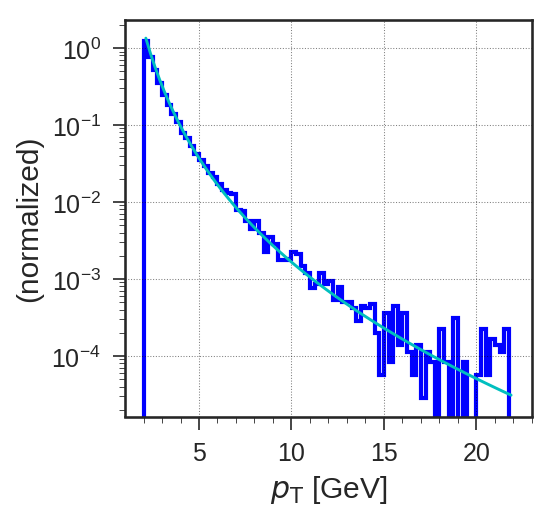

In [9]:
# Find PDF for pT

from scipy.optimize import curve_fit

def mb(x, a0, a1, a2):
  return (a0 + a1*x + a2*np.log(x))

def fit_mb(hist, edges, p0=None):
  hist = hist.astype('float64')
  edges = edges.astype('float64')
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(mb, xdata, ydata, p0=p0)
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

part_pt = np.abs(1.0/out_part[:,0])

fig, ax = plt.subplots(figsize=(3.5,3.5))
hist, edges, _ = ax.hist(part_pt, bins=80, range=(2.,22.), density=True, histtype='step', color='b', linewidth=2)
ax.set_xlabel(r'$p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'(normalized)')
ax.set_yscale('log')

# pad zero bins
hist[hist < 1e-5] = 1e-5

# bin width
binw = (22.-2.)/80
print hist.sum() * binw

# Fit
# logy, include bin width
hist1 = np.log(hist * binw)
popt = fit_mb(hist1, edges, p0=None)
print('a0, a1, a2 = ({0}, {1}, {2})'.format(*popt))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, np.exp(mb(xdata, popt[0], popt[1], popt[2]))/binw, color='c')

plt.show()

1.080854451715395


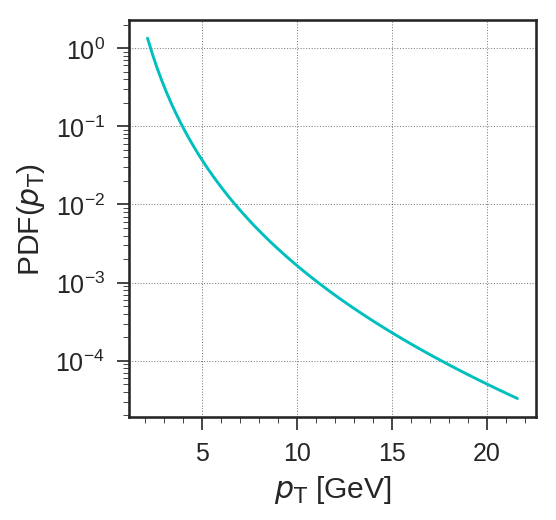

In [10]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
edges1 = np.arange(2,22,binw)
xdata1 = (edges1[1:] + edges1[:-1])/2
#print xdata, xdata1

a0, a1, a2 = (2.03833032291, -0.0755384132573, -3.93981776465)
my_func =  lambda x: np.exp(a0 + a1/x - a2*np.log(x))
ydata1 = np.apply_along_axis(my_func, 0, np.abs(1.0/xdata1))
print ydata1.sum()

ax.plot(xdata1, ydata1/binw, color='c')
ax.set_xlabel(r'$p_{\mathrm{T}}$ [GeV]')
ax.set_ylabel(r'PDF($p_{\mathrm{T}}$)')
ax.set_yscale('log')

plt.show()

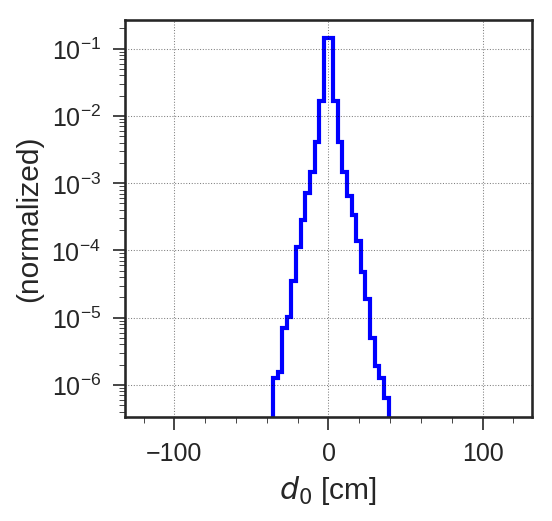

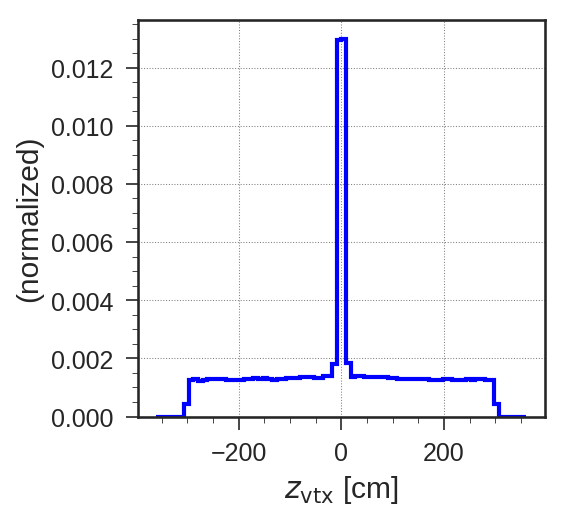

In [11]:
# Find PDF for d0

part_invPt = out_part[:,0]
part_phi   = out_part[:,1]
part_eta   = out_part[:,2]
part_vx    = out_part[:,3]
part_vy    = out_part[:,4]
part_vz    = out_part[:,5]

# Find d0
_invPt = part_invPt.astype(np.float64, copy=True)  # needs double precision
_invPt = np.where(np.abs(_invPt) < 1./10000, np.sign(_invPt) * 1./10000, _invPt)
_R = -1.0 / (0.003 * 3.811 * _invPt)           # R = -pT/(0.003 q B)  [cm]
_xc = part_vx - (_R * np.sin(part_phi))        # xc = xv - R sin(phi)
_yc = part_vy + (_R * np.cos(part_phi))        # yc = yv + R cos(phi)
_d0 = _R - (np.sign(_R) * np.hypot(_xc, _yc))  # d0 = R - sqrt(xc^2 + yc^2) * sign(R)

part_dxy = _d0.astype(np.float32, casting='same_kind')

fig, ax = plt.subplots(figsize=(3.5,3.5))
hist, edges, _ = ax.hist(part_dxy, bins=80, range=(-120, 120), density=True, histtype='step', color='b', linewidth=2)
ax.set_xlabel(r'$d_0$ [cm]')
ax.set_ylabel(r'(normalized)')
ax.set_yscale('log')

fig, ax = plt.subplots(figsize=(3.5,3.5))
hist, edges, _ = ax.hist(part_vz, bins=80, range=(-360, 360), density=True, histtype='step', color='b', linewidth=2)
ax.set_xlabel(r'$z_{\mathrm{vtx}}$ [cm]')
ax.set_ylabel(r'(normalized)')
#ax.set_yscale('log')

plt.show()

1.0
a0, a1, a2 = (-2.73990577757, -0.229635878932, -0.836964819075)


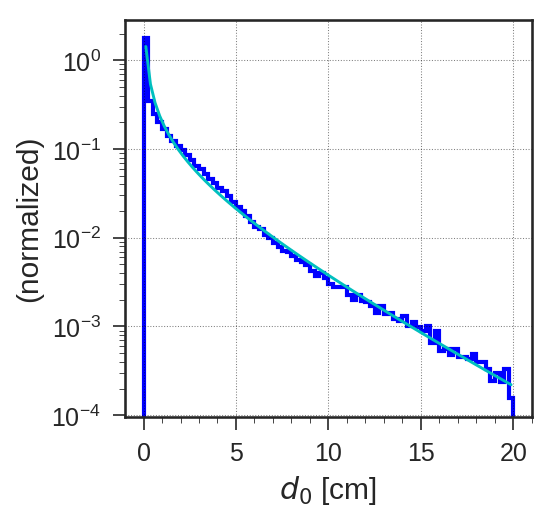

In [12]:
# Find PDF for d0

from scipy.optimize import curve_fit

def mb(x, a0, a1, a2):
  return (a0 + a1*x + a2*np.log(x))

def fit_mb(hist, edges, p0=None):
  hist = hist.astype('float64')
  edges = edges.astype('float64')
  xdata = (edges[1:] + edges[:-1])/2
  ydata = hist
  popt, pcov = curve_fit(mb, xdata, ydata, p0=p0)
  if not np.isfinite(pcov).all():
    raise Exception('Fit has failed to converge.')
  return popt

fig, ax = plt.subplots(figsize=(3.5,3.5))
hist, edges, _ = ax.hist(np.abs(part_dxy), bins=80, range=(0.,20.), density=True, histtype='step', color='b', linewidth=2)
ax.set_xlabel(r'$d_0$ [cm]')
ax.set_ylabel(r'(normalized)')
ax.set_yscale('log')

# pad zero bins
hist[hist < 1e-5] = 1e-5

# bin width
binw = (20.-0.)/80
print hist.sum() * binw

# Fit
# logy, include bin width
hist1 = np.log(hist * binw)
popt = fit_mb(hist1, edges, p0=None)
print('a0, a1, a2 = ({0}, {1}, {2})'.format(*popt))
xdata = (edges[1:] + edges[:-1])/2
ax.plot(xdata, np.exp(mb(xdata, popt[0], popt[1], popt[2]))/binw, color='c')

plt.show()

0.967058011332772


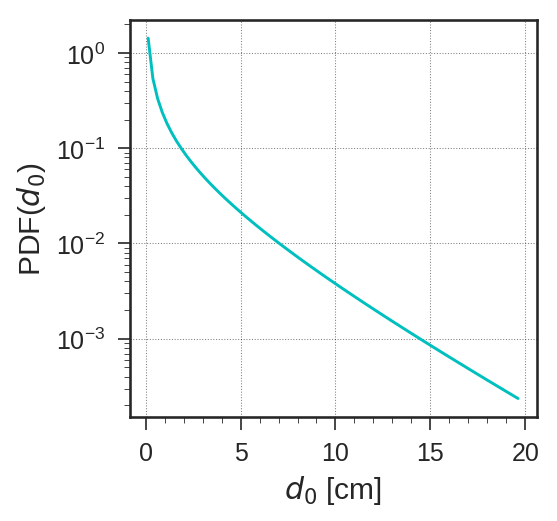

In [13]:
fig, ax = plt.subplots(figsize=(3.5,3.5))
edges1 = np.arange(0,20,binw)
xdata1 = (edges1[1:] + edges1[:-1])/2
#print xdata, xdata1

a0, a1, a2 = (-2.73990577757, -0.229635878932, -0.836964819075)
my_func =  lambda x: np.exp(a0 + a1*x + a2*np.log(x))
ydata1 = np.apply_along_axis(my_func, 0, np.abs(xdata1))
print ydata1.sum()

ax.plot(xdata1, ydata1/binw, color='c')
ax.set_xlabel(r'$d_0$ [cm]')
ax.set_ylabel(r'PDF($d_0$)')
ax.set_yscale('log')

plt.show()